In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np
import os.path
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
# Importing helper libraries for bayesian optimization
from data_preprocessing_class import dataPreprocessing
from gaussian_process_regression_class import gaussianProcessRegression
from acquisition_functions_class import acqisitionFunctions

In [2]:
"""
STEP 0:
Load the input and output data gennerated by SE model for building a GPR model

"""
# Checking if data exists
doesDataFileExist = os.path.isfile("master_feature_output.npy")

# Loading datafiles if they exist
# Else fetching and preparing data from signac workspace
if doesDataFileExist == True:
    # Loading input parameters
    master_parameter_input_n = np.load('master_parameter_input_n.npy', )
    # Loading output EFD coefficients
    master_feature_output = np.load('master_feature_output.npy', )

# Printing shape of the daya
print(np.shape(master_parameter_input_n))
print(np.shape(master_feature_output))

(133, 35)
(133, 80)


In [3]:
"""
STEP 2: Data preprocessing
1. Selects the parameters sampled in LHS from total 35 parameters of the SE model
2. PCA on the out shape features.
"""
# Loading in the data processing class
dataPreprocess  = dataPreprocessing(master_parameter_input_n, master_feature_output, 133)
# Converting the input parameters to logscale
master_parameter_input_log = dataPreprocess.inputLogTransform()
print(np.shape(master_parameter_input_log))
# Selecting the parameters that were sampled in the latin hypercube sampling
num_parameters_LHS = 7
LHS_parameter_index = [1, 4, 7, 17, 18, 19, 33]
# Calling in the function to separate out the desired parameters
data_x = dataPreprocess.inputParameterSelection(num_parameters_LHS, LHS_parameter_index, master_parameter_input_log)
print(np.shape(data_x))

# PCA to reduce dimensionality of the output data
total_variance_explained, principalComponents, weights = dataPreprocess.pcaEfdFeatures(8)
print(total_variance_explained)


C:\Users\Nilay\Documents\GitHub\Tissue-Cartography\parameter_screening\bayesian_optimization\data_preprocessing_class.py:42: RuntimeWarning: divide by zero encountered in log
  master_parameter_input = np.log(self.master_parameter_input_n)


(133, 35)
(133, 7)
0.8351040196736451


Iter 1/100 - Loss: 6.599   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 6.170   lengthscale: 0.744   noise: 0.744
Iter 3/100 - Loss: 5.798   lengthscale: 0.798   noise: 0.798
Iter 4/100 - Loss: 5.477   lengthscale: 0.853   noise: 0.853
Iter 5/100 - Loss: 5.200   lengthscale: 0.909   noise: 0.911
Iter 6/100 - Loss: 4.960   lengthscale: 0.965   noise: 0.969
Iter 7/100 - Loss: 4.752   lengthscale: 1.022   noise: 1.029
Iter 8/100 - Loss: 4.571   lengthscale: 1.077   noise: 1.090
Iter 9/100 - Loss: 4.413   lengthscale: 1.131   noise: 1.151
Iter 10/100 - Loss: 4.274   lengthscale: 1.183   noise: 1.213
Iter 11/100 - Loss: 4.151   lengthscale: 1.232   noise: 1.275
Iter 12/100 - Loss: 4.042   lengthscale: 1.279   noise: 1.337
Iter 13/100 - Loss: 3.946   lengthscale: 1.322   noise: 1.399
Iter 14/100 - Loss: 3.859   lengthscale: 1.362   noise: 1.460
Iter 15/100 - Loss: 3.782   lengthscale: 1.399   noise: 1.521
Iter 16/100 - Loss: 3.712   lengthscale: 1.433   noise: 1.581
Iter 17/100 - Los

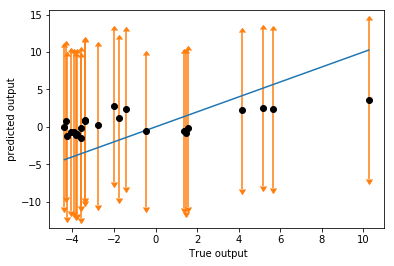

In [4]:
"""
Step 3: Training the GPR model
Input: Parametsr sampled in LHS for the SE model
Output: PC1
"""
# Normalizing data
data_x = StandardScaler().fit_transform(data_x)
data_y = principalComponents[:,0]

# To do: Incorporate it in the GPR class
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # Defining a RBF kernel
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #defing a Matern kernel
        # mu is the smoothness parameter
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Calling in the gpr class
gpr  = gaussianProcessRegression(data_x, data_y)
# Splitting up the training and test data
train_x, train_y, test_x, test_y = gpr.split_data(110, 133)
# Getting the trained model and likelihood using the training data
model, likelihood = gpr.GP_Regressor(train_x, train_y, test_x, test_y, 100, 1, ExactGPModel)

In [7]:
""" STEP 4: Acquistion function:  Expected improvenet
"""


# Defining numvber of samples
num_samples = 100

# Implementing latin hypercube sampling
x = np.random.rand(num_samples, 7)

# Calling in the acquisition function class
af = acqisitionFunctions(x, test_x, test_y)
# Calculating the xpected improvement
ei = af.expected_improvement(model, likelihood, 0.9)

print(np.shape(ei))
print(ei)



(100,)
[0.08582928 0.05421832 0.16114207 0.08395824 0.12650609 0.09580144
 0.10564311 0.19016072 0.16679908 0.16164351 0.04821438 0.14705107
 0.13288199 0.15774933 0.1851403  0.10479162 0.09772895 0.08292286
 0.10840834 0.10562157 0.1200628  0.10831008 0.09441238 0.12040841
 0.1769013  0.09250586 0.10109433 0.1026885  0.10474749 0.19364774
 0.11838184 0.0771927  0.10268387 0.15879264 0.09814043 0.1152411
 0.08355551 0.06772003 0.1590852  0.0776651  0.17470013 0.08347325
 0.13619513 0.13537448 0.11629419 0.09981836 0.14696448 0.1100847
 0.07335209 0.08620046 0.15453651 0.04633654 0.12960026 0.18244245
 0.20352047 0.04673598 0.11994851 0.02814299 0.10419951 0.19097426
 0.17613704 0.16907234 0.13194725 0.15533615 0.10809397 0.10011859
 0.18219677 0.21137306 0.15251986 0.30489176 0.21315188 0.09863263
 0.14347983 0.10475068 0.05403289 0.16006329 0.09332135 0.09866782
 0.1172341  0.15018067 0.13895967 0.11651884 0.12371559 0.11682626
 0.06962565 0.14712009 0.25977244 0.09518298 0.21924557 0